# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [41]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [42]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.0  Device: cpu


## 3. CIFAR10 데이터 다운로드 (Train data와 Test data 분리하기)

In [43]:
BATCH_SIZE = 32 

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## 4. 첫번째 batch 데이터의 크기와 타입을 확인하기

In [44]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


## 4. torch.nn을 이용하여 모델 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!


In [45]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3072, 100) # 입력층과 은닉층의 연결
        self.fc2 = nn.Linear(100, 10) # 은닉층과 출력층의 연결
        self.relu = nn.ReLU() # 은닉층에서 사용할 활성화 함수

    def forward(self, x):
        x = self.fc1(x) # 입력층과 은닉층의 연결
        x = self.relu(x) # 은닉층에서 사용할 활성화 함수
        x = self.fc2(x) # 은닉층과 출력층의 연결
        return x # 모델의 출력


## 5. 초기화를 위한 함수 만들기

In [46]:
def init_constants(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data, 0)
        nn.init.constant_(m.bias.data, 0)

def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0, std=1)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

def init_xaiver(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data ,gain=1.0)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
       
        if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

## 6. 모델 객체 만들고 다르게 초기화 하기

In [47]:
network_const = Model()
network_const.apply(init_constants)

network_normal = Model()
network_normal.apply(init_normal)

network_xavier = Model()
network_xavier.apply(init_xavier)

network_kaiming = Model()
network_kaiming.apply(init_kaiming)

Model(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [48]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        # 이미지를 (batch_size, 784) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image = image.view(batch_size, -1)

        # Forward propagration 계산하기.
        outputs = network(image)
        
        
        # Cross_entropy 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = torch.argmax(outputs, dim=1)
        train_correct += pred.eq(label).sum()
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [49]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = image.view(batch_size, -1)

            # Forward propagration 계산하기.
            outputs = network(image)

            # Cross_entropy 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

In [50]:
def training(network):
    
    learning_rate = 0.01
    epoches = 20
    
    cls_loss = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader, network, cls_loss, optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [51]:
rlt_const = training( network_const)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302585
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.301526
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.303564
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.301433

Training set: Accuracy: 4844/50000 (10%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303619
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.301910
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.303573
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.301404

Training set: Accuracy: 4730/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.303838
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.301992
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.301399

Training set: Accuracy: 4738/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.303884
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.302010
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 3 [48000/50000 (96%

In [52]:
rlt_normal = training(network_normal)

Train Epoch: 0 [0/50000 (0%)]	Loss: 323.604126
Train Epoch: 0 [16000/50000 (32%)]	Loss: 7.671056
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.254389
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.381162

Training set: Accuracy: 9742/50000 (19%)
Test set: Accuracy: 2150/10000 (22%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.434224
Train Epoch: 1 [16000/50000 (32%)]	Loss: 3.435527
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.170750
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.227003

Training set: Accuracy: 10936/50000 (22%)
Test set: Accuracy: 2290/10000 (23%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.087077
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.886665
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.159796
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.246003

Training set: Accuracy: 11254/50000 (23%)
Test set: Accuracy: 2367/10000 (24%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.010664
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.681607
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.151696
Train Epoch: 3 [48000/5000

In [53]:
rlt_xavier = training(network_xavier)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.597927
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.863469
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.862512
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.267453

Training set: Accuracy: 15994/50000 (32%)
Test set: Accuracy: 3744/10000 (37%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.786995
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.676499
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.753813
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.282531

Training set: Accuracy: 19584/50000 (39%)
Test set: Accuracy: 4137/10000 (41%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.722367
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.583171
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.720796
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.227086

Training set: Accuracy: 20960/50000 (42%)
Test set: Accuracy: 4243/10000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.712091
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.515619
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.727751
Train Epoch: 3 [48000/50000

In [54]:
rlt_kaiming = training(network_kaiming)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.770948
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.857191
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.793689
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.266225

Training set: Accuracy: 16111/50000 (32%)
Test set: Accuracy: 3438/10000 (34%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.842311
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.629051
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.689432
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.236789

Training set: Accuracy: 19594/50000 (39%)
Test set: Accuracy: 3745/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.807383
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.500590
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.611199
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.223761

Training set: Accuracy: 20929/50000 (42%)
Test set: Accuracy: 3726/10000 (37%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.863431
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.455915
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.572450
Train Epoch: 3 [48000/50000

# 학습 결과 보기 
## 1. loss 값 비교

In [55]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

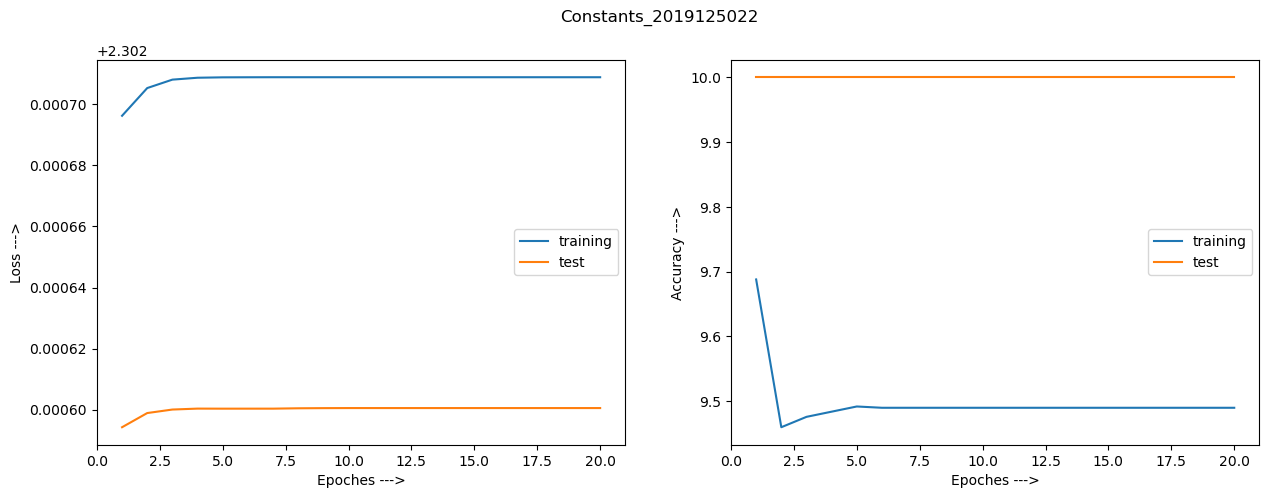

In [56]:
show_rlt(rlt_const, 'Constants_2019125022')

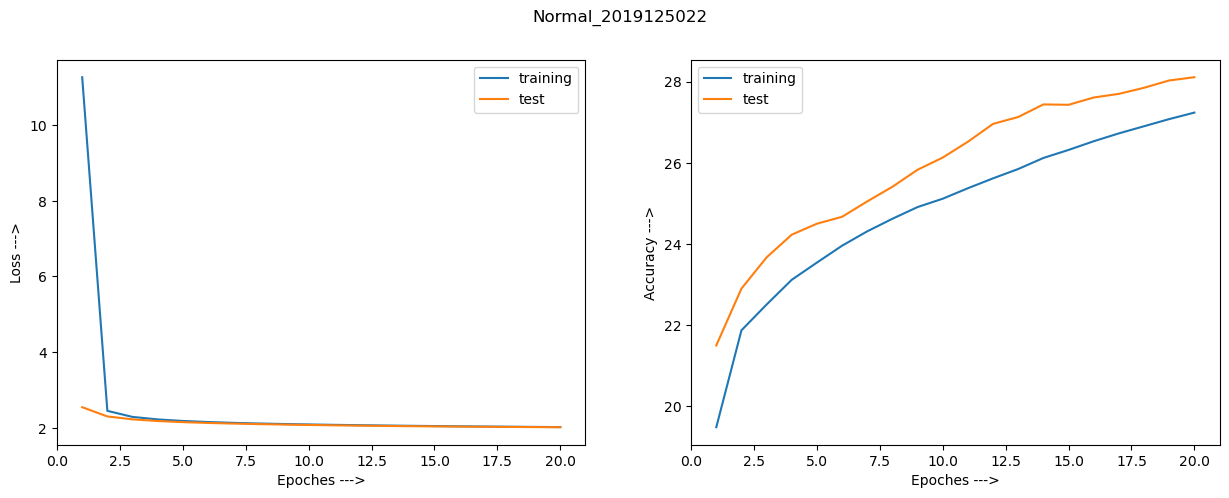

In [57]:
show_rlt(rlt_normal, 'Normal_2019125022')

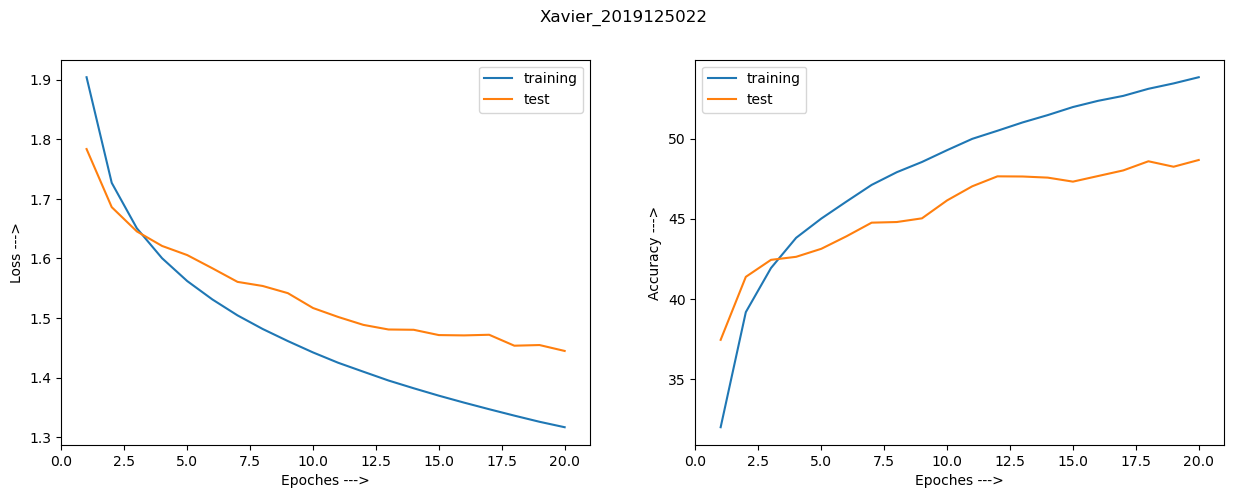

In [58]:
show_rlt(rlt_xavier, 'Xavier_2019125022')

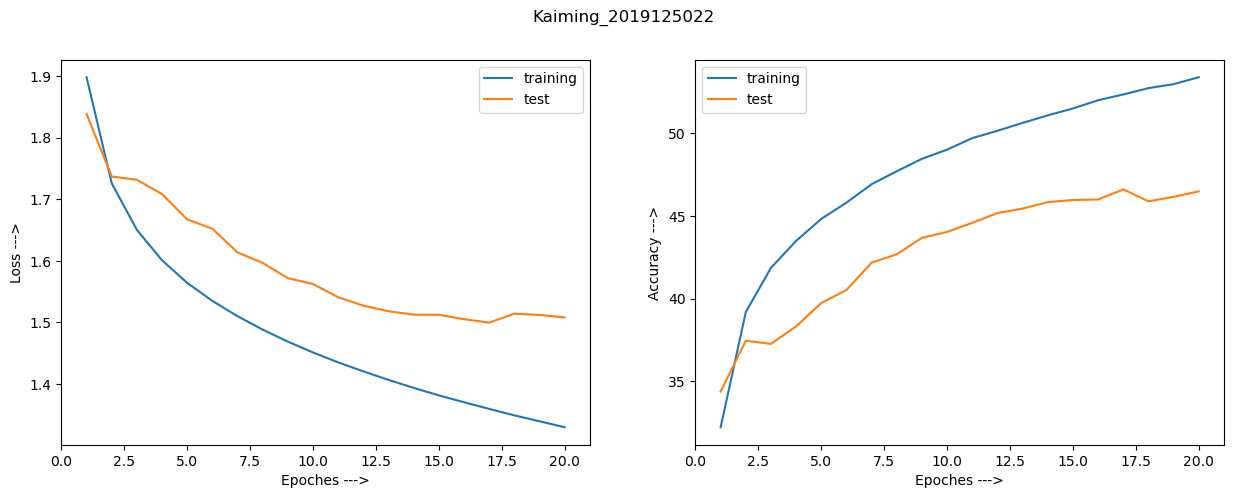

In [59]:
show_rlt(rlt_kaiming, 'Kaiming_2019125022')

## 2. 위 4개의 초기화 방법를 비교하고 성능에 대해서 분석하시오

정답)
Kaiming 초기화 방법은 ReLU 함수를 사용하는 네트워크에서 효과적입니다. 이 방법은 특히 깊은 네트워크에서 발생하는 그레디언트 소실 문제를 해결하는 데 도움이 됩니다. Kaiming 초기화 방법은 중요한 가중치를 더 잘 초기화하며, 이로 인해 더 빠른 수렴 속도와 더 높은 정확도를 달성할 수 있습니다.

Xavier 초기화 방법은 활성화 함수가 비선형인 경우에 효과적입니다. 이 초기화 방법은 중간 레이어의 출력 분산을 유지하고 입력 분산과 출력 분산을 동일하게 유지하는 것을 목표로 합니다. 이 방법은 네트워크의 가중치 분산이 합리적인 값을 유지하면서도, 그레디언트 소실 문제를 해결하는 데 도움이 됩니다.

Normal 초기화 방법은 각 가중치를 평균이 0이고 분산이 1인 정규분포에서 무작위로 초기화합니다. 이 방법은 일반적으로 네트워크의 학습을 시작할 때 사용됩니다. 하지만 이 초기화 방법은 가중치의 크기가 너무 커지거나 작아지는 문제가 발생할 수 있습니다.

Constant 초기화 방법은 모든 가중치를 0 또는 특정 값으로 설정합니다. 이 초기화 방법은 일반적으로 사용되지 않습니다.

따라서, 초기화 방법의 선택은 네트워크의 구조와 사용되는 활성화 함수에 따라 다릅니다. ReLU 함수를 사용하는 네트워크에서는 Kaiming 초기화 방법이 효과적이며, 비선형 함수를 사용하는 경우 Xavier 초기화 방법이 효과적입니다. 일반적으로, Normal 초기화 방법은 가중치 크기가 적당한 경우 초기화 방법으로 사용됩니다.

In [60]:
print("2019125022 류재혁")

2019125022 류재혁
